In [1]:
import json
import matplotlib.pyplot as plt
import polars as pl

from typing import Any
from privacy_and_grokking.path_keeper import get_path_keeper

In [2]:
RUN_ID = "v1.1.0"
MODELS = ["MLP_V1"]#, "MLP_GROK_V1", "CNN_V1", "CNN_GROK_V1"]

In [3]:
pk = get_path_keeper()
pk.set_params({"run_id": RUN_ID})

In [ ]:
def flatten_dict(d: dict[str, Any], parent_key: str = '', sep: str = '_') -> dict[str, Any]:
    items: list[tuple[str, Any]] = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [41]:
dfs = {}
for model in MODELS:
    pk.set_params({"model": model})
    metrics: list[dict] = json.loads(pk.TRAIN_METRICS.read_text())
    metrics = [flatten_dict(m) for m in metrics]
    df = pl.DataFrame(metrics)
    dfs[model] = df

In [42]:
dfs[list(dfs.keys())[0]].head()

step,train_loss,train_accuracy,test_loss,test_accuracy,norm,last_layer_norm
i64,f64,f64,f64,f64,f64,f64
0,0.000589,0.095183,0.000591,0.0907,11.738787,1.818007
1,0.000443,0.253417,0.000444,0.2716,11.74358,1.816155
2,0.000418,0.422733,0.000418,0.4305,11.753071,1.814658
3,0.000368,0.54335,0.000367,0.5455,11.762148,1.812538
4,0.000337,0.637283,0.000336,0.6401,11.772974,1.810915


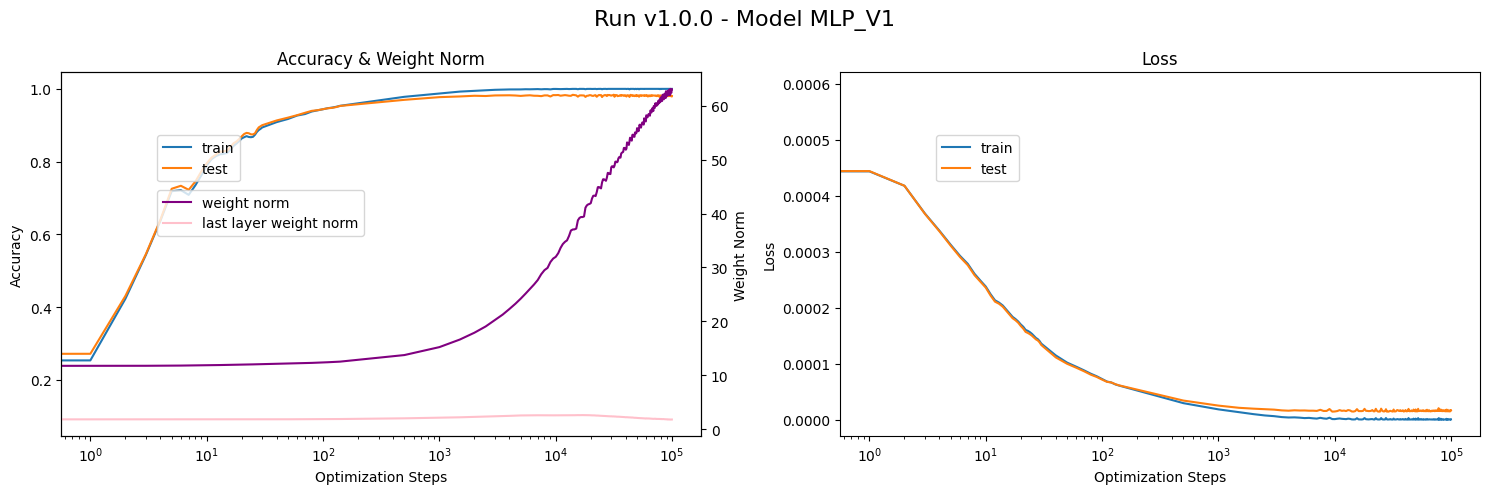

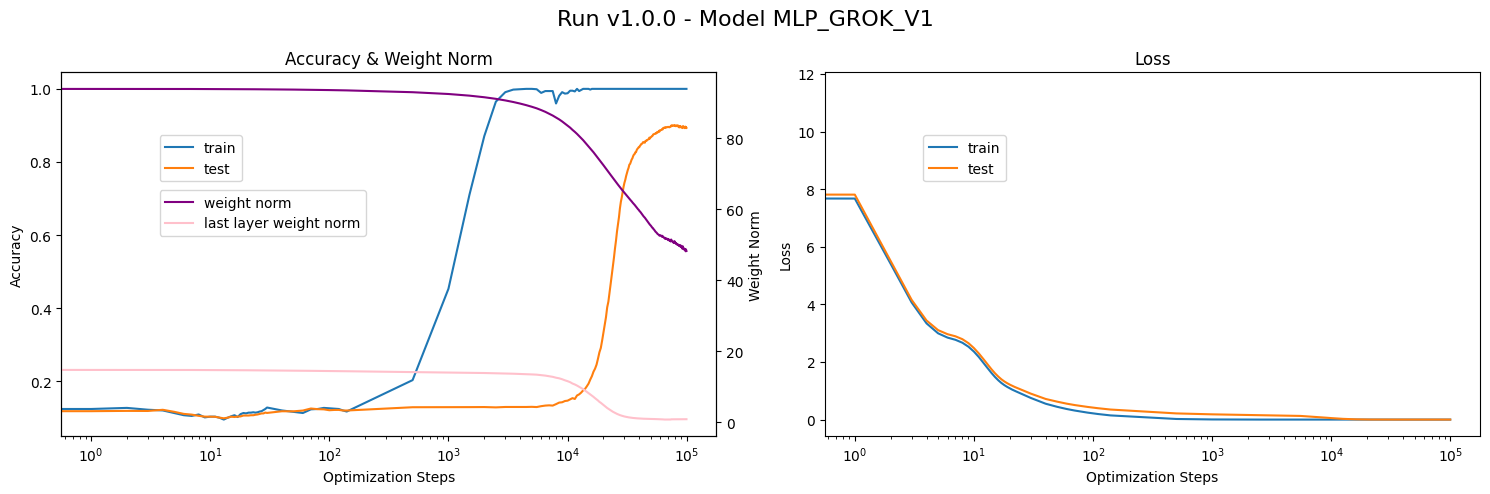

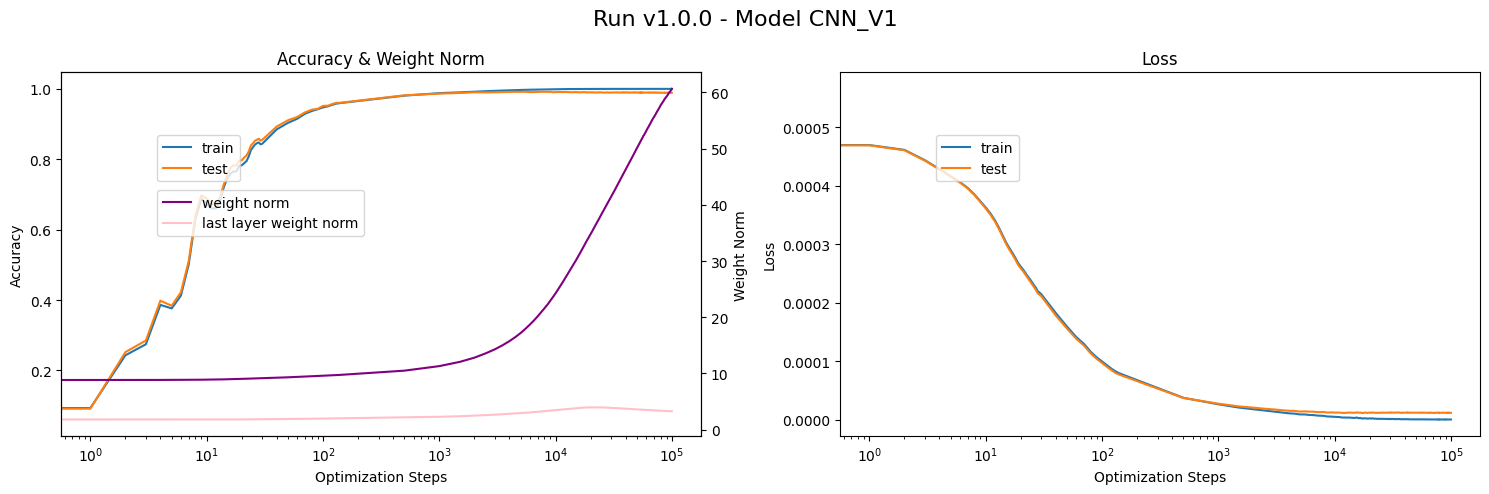

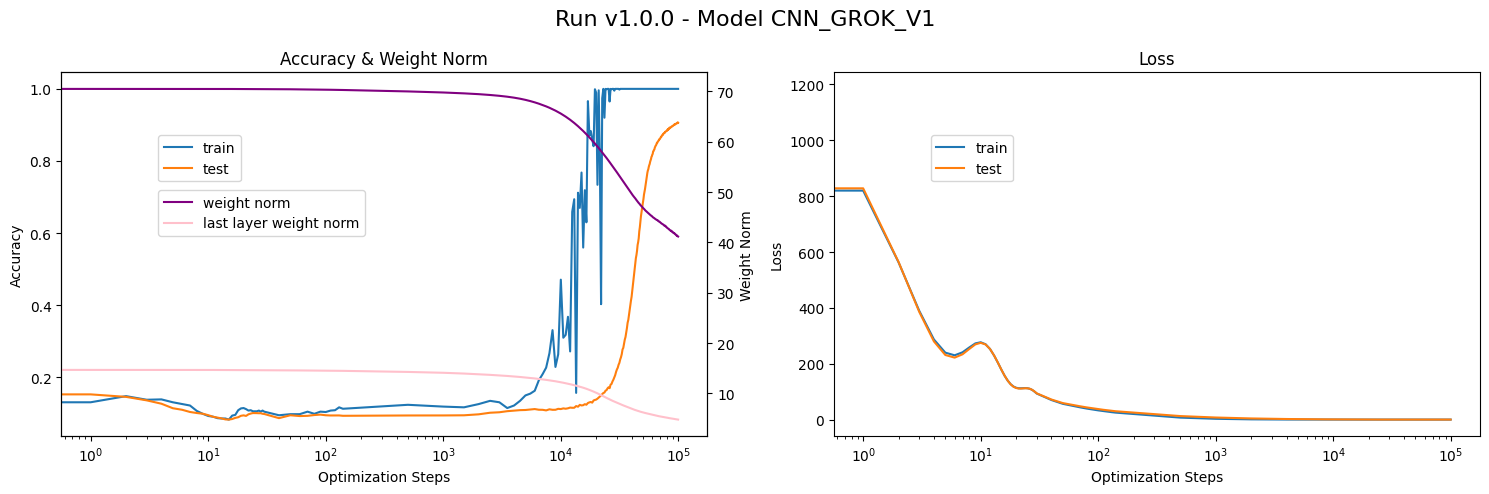

In [43]:
for model, df in dfs.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Left subplot: Accuracy and Weight Norm
    ax1.set_xlabel("Optimization Steps")
    ax1.set_xscale('log')
    ax1.set_ylabel("Accuracy")
    ax1.plot(df["step"], df["train_accuracy"], label="train")
    ax1.plot(df["step"], df["test_accuracy"], label="test")
    ax1.legend(loc=(0.15, 0.7))
    
    ax1_twin = ax1.twinx()
    ax1_twin.set_ylabel("Weight Norm")
    ax1_twin.plot(df["step"], df["norm"], color="purple", label="weight norm")
    ax1_twin.plot(df["step"], df["last_layer_norm"], color="pink", label="last layer weight norm")
    ax1_twin.legend(loc=(0.15, 0.55))
    
    ax1.set_title("Accuracy & Weight Norm")
    
    # Right subplot: Loss
    ax2.set_xlabel("Optimization Steps")
    ax2.set_xscale('log')
    ax2.set_ylabel("Loss")
    ax2.plot(df["step"], df["train_loss"], label="train")
    ax2.plot(df["step"], df["test_loss"], label="test")
    ax2.legend(loc=(0.15, 0.7))
    ax2.set_title("Loss")
    
    # Overall title
    fig.suptitle("Run {} - Model {}".format(RUN_ID, model), fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# This cell is now empty - data loading moved to the analysis cell below

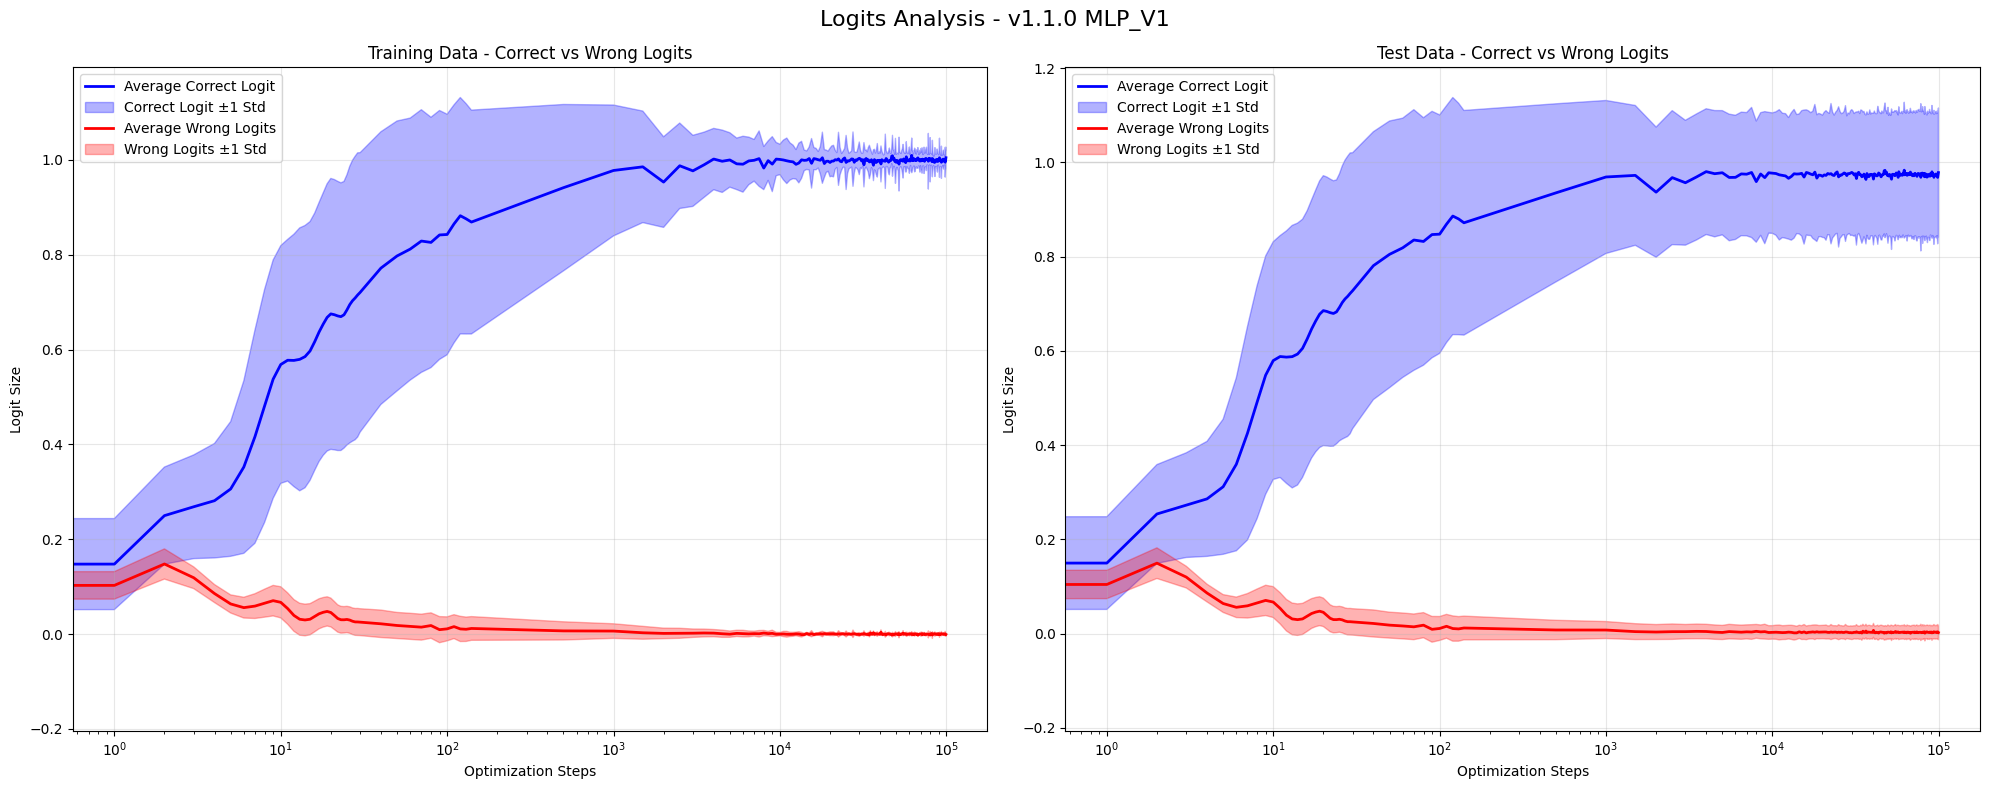


MLP_V1 Summary Statistics:
  Training - Steps range: 0 to 99500
  Training - Correct logit range: -0.037 to 1.010
  Training - Final difference (correct - wrong): 1.005
  Test - Steps range: 0 to 99500
  Test - Correct logit range: -0.038 to 0.984
  Test - Final difference (correct - wrong): 0.976
  Samples per step: Train=60000, Test=10000


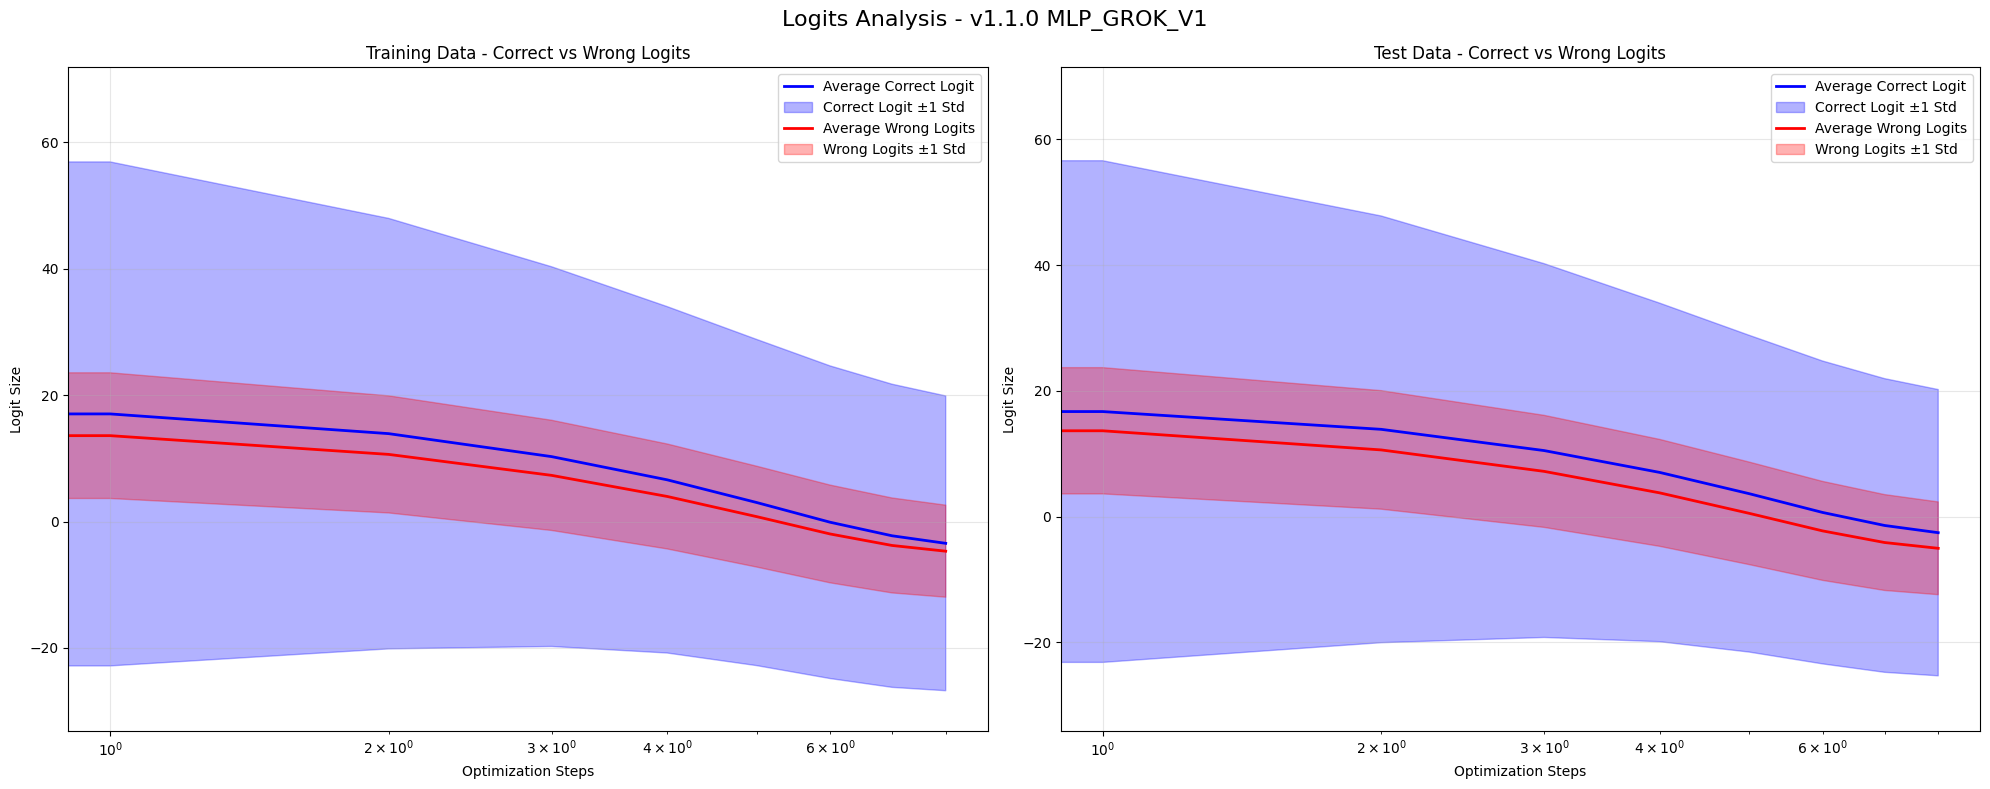


MLP_GROK_V1 Summary Statistics:
  Training - Steps range: 0 to 8
  Training - Correct logit range: -3.446 to 19.356
  Training - Final difference (correct - wrong): 1.244
  Test - Steps range: 0 to 8
  Test - Correct logit range: -2.571 to 18.663
  Test - Final difference (correct - wrong): 2.486
  Samples per step: Train=1000, Test=10000
Error processing CNN_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path expansion input: 'paths: [Local("/Users/ronholzapfel/Documents/private/privacy-and-grokking/data/runs/v1.1.0/CNN_V1/checkpoints/*/train_logits.parquet")]', glob: true). Hint: passing a schema can allow this scan to succeed with an empty DataFrame.

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'

Error processing CNN_GROK_V1: failed to retrieve first file schema (parquet): expanded paths were empty (path expansion input: 'paths: [Local("/Users/ronholzapfel/Documents/private/privacy-and-grokking/data/runs/v1.1.

In [ ]:
# Calculate correct logits size over time for all models
import numpy as np

# Update MODELS to include all available models
MODELS = ["MLP_V1", "MLP_GROK_V1", "CNN_V1", "CNN_GROK_V1"]

def process_logits_data(df_data, dataset_name):
    """Process logits data to extract correct and wrong logits"""
    df_with_logits = df_data.with_columns([
        # Correct logit - extract the logit corresponding to the correct label
        pl.concat_list([f'logit_{i}' for i in range(10)]).list.get(pl.col('correct_label')).alias('correct_logit'),
        
        # Calculate average wrong logits
        pl.struct(['correct_label'] + [f'logit_{i}' for i in range(10)])
        .map_elements(
            lambda row: float(np.mean([row[f'logit_{i}'] for i in range(10) if i != row['correct_label']])),
            return_dtype=pl.Float64
        )
        .alias('avg_wrong_logit')
    ])
    
    # Group by step and calculate statistics
    logits_by_step = (
        df_with_logits
        .group_by('step')
        .agg([
            pl.col('correct_logit').mean().alias('avg_correct_logit'),
            pl.col('correct_logit').std().alias('std_correct_logit'),
            pl.col('avg_wrong_logit').mean().alias('avg_wrong_logit'),
            pl.col('avg_wrong_logit').std().alias('std_wrong_logit'),
            pl.col('correct_logit').count().alias('count')
        ])
        .sort('step')
    )
    
    return logits_by_step

# Process data for each model
for model in MODELS:
    try:
        pk.set_params({"model": model, "step": "*"})
        
        # Load both training and test data
        df_train = pl.read_parquet(pk.TRAIN_LOGITS, glob=True)
        df_test = pl.read_parquet(pk.TEST_LOGITS, glob=True)
        
        # Process both datasets
        train_logits = process_logits_data(df_train, "train")
        test_logits = process_logits_data(df_test, "test")
        
        # Create subplot for this model
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot training data
        steps_train = train_logits['step'].to_numpy()
        avg_correct_train = train_logits['avg_correct_logit'].to_numpy()
        std_correct_train = train_logits['std_correct_logit'].to_numpy()
        avg_wrong_train = train_logits['avg_wrong_logit'].to_numpy()
        std_wrong_train = train_logits['std_wrong_logit'].to_numpy()
        
        ax1.plot(steps_train, avg_correct_train, 'b-', linewidth=2, label='Average Correct Logit')
        ax1.fill_between(steps_train, avg_correct_train - std_correct_train, avg_correct_train + std_correct_train, 
                        alpha=0.3, color='blue', label='Correct Logit ±1 Std')
        ax1.plot(steps_train, avg_wrong_train, 'r-', linewidth=2, label='Average Wrong Logits')
        ax1.fill_between(steps_train, avg_wrong_train - std_wrong_train, avg_wrong_train + std_wrong_train, 
                        alpha=0.3, color='red', label='Wrong Logits ±1 Std')
        
        ax1.set_xlabel('Optimization Steps')
        ax1.set_ylabel('Logit Size')
        ax1.set_title(f'Training Data - Correct vs Wrong Logits')
        ax1.set_xscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot test data
        steps_test = test_logits['step'].to_numpy()
        avg_correct_test = test_logits['avg_correct_logit'].to_numpy()
        std_correct_test = test_logits['std_correct_logit'].to_numpy()
        avg_wrong_test = test_logits['avg_wrong_logit'].to_numpy()
        std_wrong_test = test_logits['std_wrong_logit'].to_numpy()
        
        ax2.plot(steps_test, avg_correct_test, 'b-', linewidth=2, label='Average Correct Logit')
        ax2.fill_between(steps_test, avg_correct_test - std_correct_test, avg_correct_test + std_correct_test, 
                        alpha=0.3, color='blue', label='Correct Logit ±1 Std')
        ax2.plot(steps_test, avg_wrong_test, 'r-', linewidth=2, label='Average Wrong Logits')
        ax2.fill_between(steps_test, avg_wrong_test - std_wrong_test, avg_wrong_test + std_wrong_test, 
                        alpha=0.3, color='red', label='Wrong Logits ±1 Std')
        
        ax2.set_xlabel('Optimization Steps')
        ax2.set_ylabel('Logit Size')
        ax2.set_title(f'Test Data - Correct vs Wrong Logits')
        ax2.set_xscale('log')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Overall title
        fig.suptitle(f'Logits Analysis - {RUN_ID} {model}', fontsize=16)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {model}: {e}")
        continue

In [13]:
df_test.head()

index,correct_label,logit_0,logit_1,logit_2,logit_3,logit_4,logit_5,logit_6,logit_7,logit_8,logit_9,step
i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32
0,7,0.061834,-0.076886,-0.105379,-0.181441,0.04289,0.087381,0.038348,-0.069902,-0.107461,0.042236,0
1,2,0.170109,-0.08371,-0.122227,-0.219125,0.135747,-0.039597,0.126126,-0.094544,-0.079856,0.156604,0
2,1,-0.021867,-0.056662,-0.176478,-0.084102,0.073524,0.043387,0.004024,-0.071488,-0.087937,0.023986,0
3,0,0.084816,-0.017283,-0.082165,-0.157906,0.155835,0.068322,0.087063,-0.063974,-0.167524,0.104828,0
4,4,0.077119,-0.161358,-0.11884,-0.104097,0.101175,0.078149,0.025323,-0.112192,-0.101042,0.038983,0


In [15]:
df_test.describe()

statistic,index,correct_label,logit_0,logit_1,logit_2,logit_3,logit_4,logit_5,logit_6,logit_7,logit_8,logit_9,step
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",790000.0,790000.0,790000.0,790000.0,790000.0,790000.0,790000.0,790000.0,790000.0,790000.0,790000.0,790000.0,790000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",4999.5,4.4434,0.096045,0.113343,0.098839,0.100137,0.100268,0.085524,0.09894,0.103387,0.094764,0.100253,4467.78481
"""std""",2886.753159,2.895722,0.27213,0.297952,0.27025,0.259457,0.253854,0.2332,0.266038,0.27111,0.250468,0.253049,5971.383375
"""min""",0.0,0.0,-0.35559,-0.385411,-0.449729,-0.418461,-0.353818,-0.403325,-0.41043,-0.353658,-0.510369,-0.382512,0.0
"""25%""",2500.0,2.0,-0.007179,-0.007893,-0.00959,-0.005609,-0.005317,-0.007123,-0.004446,-0.007899,-0.005625,-0.007241,19.0
"""50%""",5000.0,4.0,0.001448,0.003176,0.002682,0.005794,0.005305,0.00453,0.003449,0.006262,0.004726,0.004531,120.0
"""75%""",7499.0,7.0,0.045365,0.060121,0.0756,0.085007,0.090572,0.081709,0.061803,0.071062,0.086831,0.089316,9000.0
"""max""",9999.0,9.0,1.589123,1.319126,1.575292,1.531767,1.569947,1.571451,1.56227,1.57144,1.457453,1.472721,18500.0


In [14]:
df_test

index,correct_label,logit_0,logit_1,logit_2,logit_3,logit_4,logit_5,logit_6,logit_7,logit_8,logit_9,step
i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32
0,7,0.061834,-0.076886,-0.105379,-0.181441,0.04289,0.087381,0.038348,-0.069902,-0.107461,0.042236,0
1,2,0.170109,-0.08371,-0.122227,-0.219125,0.135747,-0.039597,0.126126,-0.094544,-0.079856,0.156604,0
2,1,-0.021867,-0.056662,-0.176478,-0.084102,0.073524,0.043387,0.004024,-0.071488,-0.087937,0.023986,0
3,0,0.084816,-0.017283,-0.082165,-0.157906,0.155835,0.068322,0.087063,-0.063974,-0.167524,0.104828,0
4,4,0.077119,-0.161358,-0.11884,-0.104097,0.101175,0.078149,0.025323,-0.112192,-0.101042,0.038983,0
…,…,…,…,…,…,…,…,…,…,…,…,…
9995,2,-0.001752,0.005922,1.001568,-0.00388,-0.005102,0.000409,-0.002428,-0.002869,-0.000024,-0.002645,9500
9996,3,0.00016,-0.006552,-0.002812,0.994096,-0.008358,0.007798,-0.000622,0.005558,-0.001261,0.002159,9500
9997,4,0.000938,0.005163,0.006301,-0.00416,0.984049,0.000601,0.0012,0.019166,0.001456,-0.007958,9500
